# Handwritten Digit Recognition Project

## 1. Import all Libraries

In [1]:
import numpy as np
from needed import imresize
from PIL import Image
import cv2  
from skimage.feature import hog
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

## 2. Define all funtions 

In [2]:
DIGIT_WIDTH = 10
DIGIT_HEIGHT = 20
IMG_HEIGHT = 28
IMG_WIDTH = 28
CLASS_N = 10  

def split(img, cell_size, flatten=True):
    h, w = img.shape[:2]
    sx, sy = cell_size
    cells = [np.hsplit(row, w // sx) for row in np.vsplit(img, h // sy)]
    cells = np.array(cells)
    if flatten:
        cells = cells.reshape(-1, sy, sx)
    return cells


def load_digits(fn):
    print('loading "%s for training" ...' % fn)
    digits_img = cv2.imread(fn, 0)
    digits = split(digits_img, (DIGIT_WIDTH, DIGIT_HEIGHT))
    resized_digits = []
    for digit in digits:
        resized_digits.append(imresize(digit, (IMG_WIDTH, IMG_HEIGHT)))
    labels = np.repeat(np.arange(CLASS_N), len(digits) / CLASS_N)
    return np.array(resized_digits), labels


def px_to_hog(img_array):
    hog_featuresData = []
    for img in img_array:
        fd = hog(img,
                 orientations=10,
                 pixels_per_cell=(5, 5),
                 cells_per_block=(1, 1))
        hog_featuresData.append(fd)
    hog_features = np.array(hog_featuresData, 'float64')
    return np.float32(hog_features)


class KNN_MODEL():
    def __init__(self, k=3):
        self.k = k
        self.model = cv2.ml.KNearest_create()

    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        retval, results, neigh_resp, dists = self.model.findNearest(samples, self.k)
        return results.ravel()


def find_digits(contours, hierarchy):
    hierarchy = hierarchy[0]
    bounding_rectangles = [cv2.boundingRect(ctr) for ctr in contours]
    final_bounding_rectangles = []
    
    u, indices = np.unique(hierarchy[:, -1], return_inverse=True)
    most_common_heirarchy = u[np.argmax(np.bincount(indices))]

    for r, hr in zip(bounding_rectangles, hierarchy):
        x, y, w, h = r
        if ((w * h) > 250) and (10 <= w <= 200) and (10 <= h <= 200) and hr[3] == most_common_heirarchy:
            final_bounding_rectangles.append(r)

    return final_bounding_rectangles


def proc_user_img(img_file, model):
    print('loading "%s for digit recognition" ...' % img_file)
    im = cv2.imread(img_file)
    blank_image = np.zeros((im.shape[0], im.shape[1], 3), np.uint8)
    blank_image.fill(255)

    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    plt.imshow(imgray)
    kernel = np.ones((5, 5), np.uint8)

    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    thresh = cv2.erode(thresh, kernel, iterations=1)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    thresh = cv2.erode(thresh, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    digits_rectangles = find_digits(contours, hierarchy)  

    for rect in digits_rectangles:
        x, y, w, h = rect
        cv2.rectangle(im, (x, y), (x + w, y + h), (0,255,0), 2)
        im_digit = imgray[y:y + h, x:x + w]
        im_digit = (255 - im_digit)
        im_digit = imresize(im_digit, (IMG_WIDTH, IMG_HEIGHT))

        hog_img_data = px_to_hog([im_digit])
        pred = model.predict(hog_img_data)
        cv2.putText(im, str(int(pred[0])), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (165,42,42), 3)
        cv2.putText(blank_image, str(int(pred[0])), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 5)

    plt.title('Overlay Image', fontweight = 'bold')
    plt.imshow(im)
    cv2.imwrite("output1.png", im)
 
    cv2.imwrite("final.png", blank_image)


def get_contour_precedence(contour, cols):
    return contour[1] * cols + contour[0]

def load_digits_custom(img_file):
    train_data = []
    train_target = []
    start_class = 1
    im = cv2.imread(img_file)
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    plt.imshow(imgray)
    kernel = np.ones((5, 5), np.uint8)

    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    thresh = cv2.erode(thresh, kernel, iterations=1)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    thresh = cv2.erode(thresh, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    digits_rectangles = find_digits(contours, hierarchy)  
    
    digits_rectangles.sort(key=lambda x: get_contour_precedence(x, im.shape[1]))

    for index, rect in enumerate(digits_rectangles):
        x, y, w, h = rect
        cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 2)
        im_digit = imgray[y:y + h, x:x + w]
        im_digit = (255 - im_digit)

        im_digit = imresize(im_digit, (IMG_WIDTH, IMG_HEIGHT))
        train_data.append(im_digit)
        train_target.append(start_class % 10)

        if index > 0 and (index + 1) % 10 == 0:
            start_class += 1
    cv2.imwrite("output1.png", im)

    return np.array(train_data), np.array(train_target)

def max(a):
    max = a[0]
    for i in range(len(a)):
        while a[i]>max:
            max=a[i]
            j=i
    return j

## 3. Data Preparation

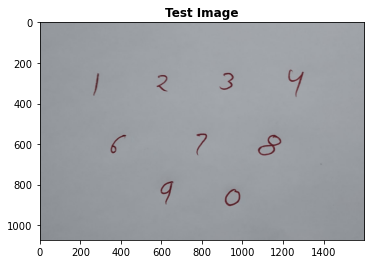

In [3]:
TRAIN_MNIST_IMG = 'digits.png'
TRAIN_USER_IMG = ['train1.jpg','train2.jpg','train3.jpg','train4.jpg','train5.jpg']
Accuracy = []
TEST_USER_IMG = 'test.png'

plt.title('Test Image', fontweight = 'bold')
plt.imshow(cv2.imread(TEST_USER_IMG))

Accuracy of  1 : 0.8235294117647058
Accuracy of  2 : 0.9393939393939394
Accuracy of  3 : 0.7352941176470589
Accuracy of  4 : 0.8235294117647058
Accuracy of  5 : 0.90625
Dataset having max accuracy is :  2


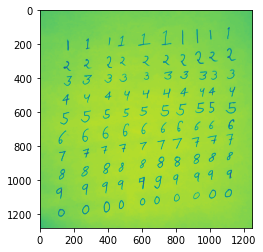

In [4]:
for i in range(len(TRAIN_USER_IMG)):
    # digits, labels = load_digits(TRAIN_MNIST_IMG) #original MNIST data (not good detection)
    digits, labels = load_digits_custom(
        TRAIN_USER_IMG[i]) # my handwritten dataset (better than MNIST on my handwritten digits)

    digits, labels = shuffle(digits, labels, random_state=256)

    
    train_digits_data = px_to_hog(digits)
    X_train, X_test, y_train, y_test = train_test_split(train_digits_data, labels, test_size=0.33, random_state=42)

    model = KNN_MODEL(k=3)
    model.train(X_train, y_train)
    preds = model.predict(X_test)
    print('Accuracy of ',i+1,':', accuracy_score(y_test, preds))
    
    Accuracy.append(accuracy_score(y_test, preds))
print("Dataset having max accuracy is : ", max(Accuracy)+1) 
digits, labels = load_digits_custom(
        TRAIN_USER_IMG[max(Accuracy)])

## 4. Training & Testing

0.9393939393939394
loading "test.png for digit recognition" ...


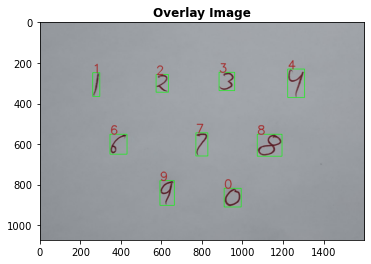

In [5]:
digits, labels = shuffle(digits, labels, random_state=256)
train_digits_data = px_to_hog(digits)
X_train, X_test, y_train, y_test = train_test_split(train_digits_data, labels, test_size=0.33, random_state=42)

model = KNN_MODEL(k=3)
model.train(X_train, y_train)
preds = model.predict(X_test)
print(accuracy_score(y_test, preds))

model = KNN_MODEL(k=2)
model.train(train_digits_data, labels)
proc_user_img(TEST_USER_IMG, model)

## 5. Final Output

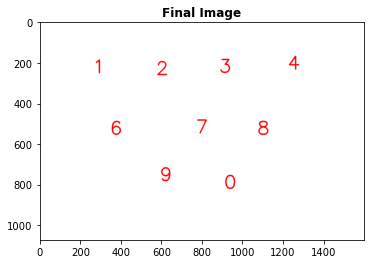

In [6]:
plt.title('Final Image', fontweight = 'bold')
plt.imshow(cv2.imread("final.png"))